<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

Загрузим необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
import re
import spacy
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import notebook
from pymystem3 import Mystem
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from nltk.corpus import stopwords as nltk_stopwords
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

Сохраним датасет в переменную и просмотрим его.

In [2]:
try:
    df_toxic = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df_toxic = pd.read_csv('toxic_comments.csv')

In [3]:
df_toxic.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Подготовим признаки. Загрузим библиотеку для обработки текста модуля spacy.

In [4]:
nlp = spacy.load('en_core_web_sm')

Напишем функцию для лемматизации и очистки текста.

In [5]:
def lemma_clear(text):
    text = text.lower()
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])
    lemm = re.sub(r'[^a-zA-Z ]',' ',lemm)
  
    return " ".join(lemm.split())

Подготовим текст.

In [6]:
df_toxic['lemm_text'] = df_toxic['text'].apply(lemma_clear)

df_toxic = df_toxic.drop(['text'], axis=1)

In [7]:
df_toxic.head()

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I be see...
2,0,hey man I be really not try to edit war it be ...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...


Проверим баланс данных.

Text(16.299999999999997, 0.5, 'toxic')

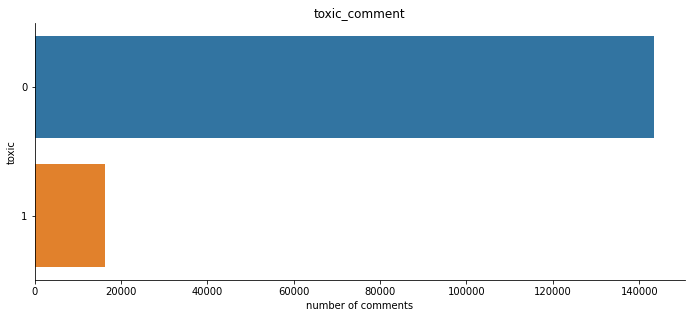

In [8]:
g = sns.catplot(kind = 'count', y = 'toxic', data = df_toxic)
g.fig.set_figwidth(10)
g.fig.set_figheight(4)
plt.title('toxic_comment')
plt.xlabel('number of comments')
plt.ylabel('toxic')

Данные несбалансированы. Для балансировки в дальнейшем используем вес классов.

Разделим данные на признаки и целевой признак.

In [9]:
features = df_toxic['lemm_text']
target = df_toxic['toxic']

Разделим признаки на тренировочную, валидационную и тестовую выборки.

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=2022)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=2022)

Произведем векторизацию текстов.

In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
features_train = count_tf_idf.fit_transform(features_train.values.astype('U'))
features_valid = count_tf_idf.transform(features_valid.values.astype('U'))
features_test = count_tf_idf.transform(features_test.values.astype('U'))

Проверим размеры.

In [13]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95742, 113570)
(31914, 113570)
(31915, 113570)


## CatBoost

Инициализируем CatBoostClassifier.

In [14]:
%%time

CBC = CatBoostClassifier(verbose=False, iterations=300)
CBC.fit(features_train, target_train)
target_predict = CBC.predict(features_valid)
cv_f1_CBC = cross_val_score(CBC,
                            features_train,
                            target_train,
                            cv=3,
                            scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7312952118422927
F1 на валидации 0.7554999105705599
CPU times: user 31min 20s, sys: 16.9 s, total: 31min 36s
Wall time: 31min 47s


## LogisticRegression

Создадим переменную для балансировки данных.

In [15]:
class_ratio = df_toxic['toxic'].value_counts()[0] / df_toxic['toxic'].value_counts()[1]

dict_classes={0:1, 1:class_ratio}

Инициализируем модель LogisticRegression, а также выберем параметры для подбора наилучшей комбинации методом GridSearch.

In [16]:
%%time

LR = LogisticRegression(random_state=2022)
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print()
clf = GridSearchCV(LR, hyperparams, scoring='f1',cv=3, n_jobs=-1)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Результаты расчета метрики при различных комбинациях параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшие параметры:

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}

Результаты расчета метрики при различных комбинациях параметров:

0.714281 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.714306 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.714293 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.752945 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.752909 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.752911 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.759608 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.760313 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.759608 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

CPU times: user 3min 4

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
%%time

LR = LogisticRegression(random_state=2022)
LR.set_params(**LR_best_params)
LR.fit(features_train, target_train)
target_predict = LR.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7603127617356682
F1 на валидации 0.772502184678124
CPU times: user 15.2 s, sys: 34.7 s, total: 50 s
Wall time: 50.1 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SGDClassifier

Инициализируем модель SGDClassifier, выберем параметры для подбора методом GridSearch, подберем наилучшую комбинацию.

In [18]:
%%time

SGD = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[2022],
                'class_weight':[dict_classes]}]


print()
clf = GridSearchCV(SGD, hyperparams, scoring='f1',cv=3, n_jobs=-1)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
SGD_best_params = clf.best_params_
print(SGD_best_params)
print()
print("Результаты расчета метрики при различных комбинациях параметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGD = max(means)


Лучшие параметры:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.5, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 2022}

Результаты расчета метрики при различных комбинациях параметров:

0.740053 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 2022}
0.722026 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 2022}
0.750048 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 2022}
0.739787 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 2022}
0.721827 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 2022}
0.751110 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'et

In [19]:
%%time

SGD = SGDClassifier()
SGD.set_params(**SGD_best_params)
SGD.fit(features_train, target_train)
target_predict = SGD.predict(features_valid)
valid_f1_SGD = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGD)
print('F1 на валидации', valid_f1_SGD)

F1 на cv 0.7554651960866616
F1 на валидации 0.7616951018161806
CPU times: user 2.03 s, sys: 110 ms, total: 2.14 s
Wall time: 2.17 s


Обобщим результаты.

In [20]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_CBC,
                    cv_f1_SGD],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_CBC,
                           valid_f1_SGD]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75

Все модели подходят для финального тестирования.

## Итоговое тестирование моделей

In [21]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
predict_test = classificator.predict(features_test)

print('LogisticRegression')
f1_LR = f1_score(target_test, predict_test)
print('F1:',f1_LR)

LogisticRegression
F1: 0.7634206337722472
CPU times: user 15.7 s, sys: 35.7 s, total: 51.3 s
Wall time: 51.5 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=300)
classificator.fit(features_train, target_train)
predict_test = classificator.predict(features_test)

print('CatBoostClassifier')
f1_CBC = f1_score(target_test, predict_test)
print('F1:', f1_CBC)

CatBoostClassifier
F1: 0.7518663348738003
CPU times: user 10min 26s, sys: 6.94 s, total: 10min 33s
Wall time: 10min 40s


In [23]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGD_best_params)
classificator.fit(features_train, target_train)
predict_test = classificator.predict(features_test)

print('SGDClassifier')
f1_SGD = f1_score(target_test, predict_test)
print('F1:', f1_SGD)

SGDClassifier
F1: 0.7614993821227518
CPU times: user 2.39 s, sys: 118 ms, total: 2.51 s
Wall time: 2.55 s


## Вывод

In [ ]:
report = pd.DataFrame(columns = ["CatBoost","LogisticRegression","SGDClassifier"],
                      index = ["F1",
                               "Время обучения и предсказания(с)"])


report.iloc[0] = [f1_CBC,f1_LR,f1_SGD]
report.iloc[1] = ["3m 31s", "3.45s", "1.07s"]

In [ ]:
report

Исходя из полученных результатов можно сделать следующие выводы:
- по качеству предсказания модели получились примерно одного уровня
- наиболее медленная модель в обучении - CatBoost, наиболее быстрая - SGDClassifier
- наиболее медленная модель в предсказании - CatBoost, наиболее быстрая - LogisticRegression

Исходя из выше сказанного, наиболее выигрышная модель SGDClassifier, хоть она и незначительно проигрывает по качеству и времени предсказания.